In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Generate synthetic data
np.random.seed(42)
import seaborn as sns
from tqdm.auto import tqdm


/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [3]:
# from nuclearpy_models.models.rc import sr_rc, mnp_rc
import sys
sys.path.append('../../nuclearpy_models')
from models.rc import sr_rc, mnp_rc

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize.minpack as minpack
from scipy.optimize import curve_fit


In [5]:
df = pd.read_csv('../../Data/Experimental/rc_train.csv').query('Z<=50').query('Z>=12')
# replace the points with delta_Rav = 0 with 1e-7
df['delta_Rav'] = df['delta_Rav'].replace(0., 1e-7)

In [6]:
def resample_data(df):
    fdf = df.copy()
    observable = df.Rav
    experimental_uncertainty = df.delta_Rav
    # sample from a normal distribution with the mean and standard deviation of the experimental uncertainty
    fdf.Rav = np.random.normal(observable, experimental_uncertainty)
    return fdf

In [9]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd
import joblib

def resample_data(df):
    fdf = df.copy()
    observable = df['Rav'].values
    experimental_uncertainty = df['delta_Rav'].values
    # Ensure sampling for each data point
    fdf['Rav'] = np.random.normal(observable, experimental_uncertainty)
    return fdf

def parametrized_sum(ZN, *weights):
    preds = []
    Zs, Ns = ZN
    for Z, N in zip(Zs, Ns):
        preds_per_term = [sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)]
        preds.append(np.dot(weights, preds_per_term))
    return preds

def bayesian_fit(df, N_ITERATIONS=100):
    data = df.copy().sample(frac=0.8, replace=True)
    data['Rav'] = data['Rav'].astype(float)
    data['delta_Rav'] = data['delta_Rav'].astype(float)

    optimal_parameters = []
    # Multiple iterations to account for the uncertainty in the data
    # do it in parallel
    get_params_opt = lambda data: curve_fit(parametrized_sum, data[["Z", "N"]].values.T, data["Rav"].values, p0=np.ones(sr_rc.max_index))[0]
    optimal_parameters = joblib.Parallel(n_jobs=16, verbose=10)(joblib.delayed(get_params_opt)(resample_data(data)) for _ in range(N_ITERATIONS))
    return np.array(optimal_parameters)


In [10]:
optimal_parameters = bayesian_fit(df, N_ITERATIONS = 100)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   24.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:   24.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   35.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:   44.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:   53.3s
[Parallel(n_jobs=16)]: Done  80 out of 100 | elapsed:   54.0s remaining:   13.5s
[Parallel(n_jobs=16)]: Done  91 out of 100 | elapsed:  1.1min remaining:    6.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.1min finished


In [11]:
optimal_parameters

array([[ 1.00168278e+00,  1.14823633e+00,  1.05412256e+00,
         1.43245912e+00,  1.84348857e+00,  8.99135846e-01,
         9.97354657e-01, -2.03144509e-01,  3.91448453e-01,
         1.60744409e+00],
       [ 1.00154575e+00,  1.09675744e+00,  1.01225338e+00,
         1.60670354e+00,  1.63126392e+00,  1.39147339e+00,
         9.92234333e-01,  2.02735343e-01,  1.80860607e+00,
         2.08793504e+00],
       [ 1.00188183e+00,  1.08045140e+00,  1.00472704e+00,
         1.46978379e+00,  1.24920130e+00,  2.29777168e+00,
         1.03753521e+00, -2.76765182e-01,  1.68098857e+00,
         9.10146025e-01],
       [ 1.00187074e+00,  1.19130457e+00,  1.08418819e+00,
         1.71907564e+00,  1.66832235e+00,  1.31508625e+00,
         8.48825177e-01, -4.99247227e-01,  1.31824240e+00,
         2.07579902e+00],
       [ 1.00151939e+00,  1.16503390e+00,  1.17758842e+00,
         1.01254140e+00,  1.25272154e+00,  7.53510532e-01,
         9.66370421e-01, -7.85179821e-02,  9.25501543e-01,
         1.

Some plots to show the distribution of the data and the correlation between the features.

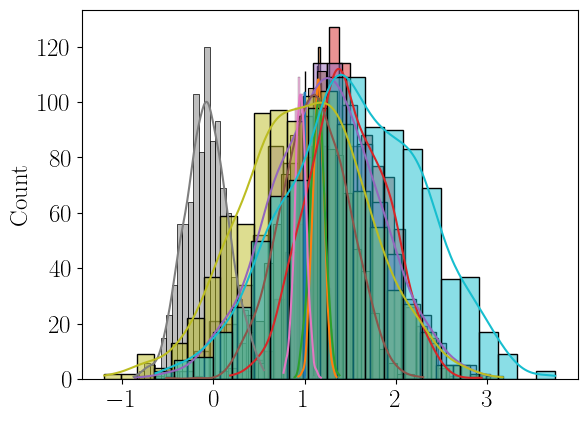

In [12]:
for i in range(sr_rc.max_index):
    std_param = np.std(optimal_parameters[:, i])
    mean_param = np.mean(optimal_parameters[:, i])
    gaussian = np.random.normal(mean_param, std_param, 1000)
    sns.histplot(gaussian, kde=True)

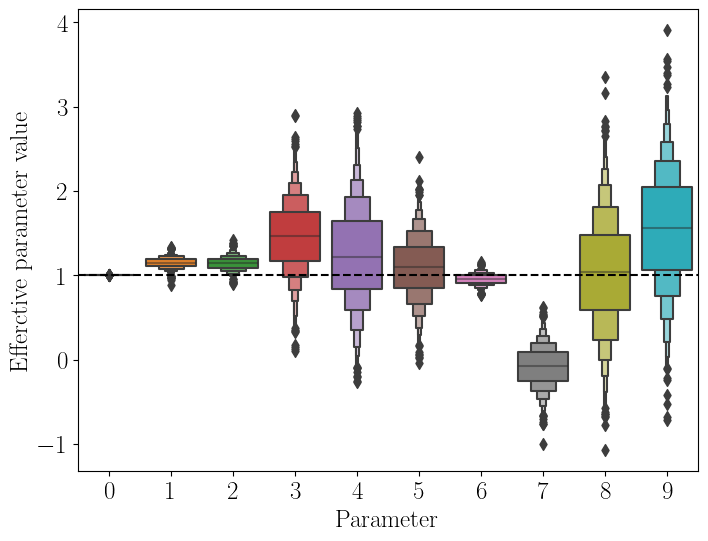

In [14]:
# Same as before, but with a better looking boxenplot on different x values
fig, ax = plt.subplots(figsize=(8, 6))
store_dict = {"param": [], "value": []}
for i in range(sr_rc.max_index):
    std_param = np.std(optimal_parameters[:, i])
    mean_param = np.mean(optimal_parameters[:, i])
    gaussian = np.random.normal(mean_param, std_param, 1000)
    store_dict["param"] += [i]*1000
    store_dict["value"] += list(gaussian)
store_df = pd.DataFrame(store_dict)
sns.boxenplot(data=store_df, x="param", y="value", ax=ax)
ax.set_xlabel("Parameter")
ax.set_ylabel("Efferctive parameter value")
# line at 1
ax.axhline(1, color="black", linestyle="--")

Inference with uncertainty

In [21]:
def predict_with_uncertainty_boostrapping(Z, N, optimal_parameters_mean=optimal_parameters.mean(axis=0), optimal_parameters_std=optimal_parameters.std(axis=0),    N_ITERATIONS=10000):
    preds_per_term = np.array([sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)])
    # generate a normal distribution for each parameter
    preds = np.dot(np.random.normal(optimal_parameters_mean, optimal_parameters_std, (N_ITERATIONS, sr_rc.max_index)), preds_per_term)
    # then, the final prediction is the mean of the predictions and the uncertainty is the maximum of the error
    max_error = np.max(np.abs(preds - preds.mean(axis=0)), axis=0)
    return preds.mean(), max_error


In [30]:
def simple_predict(Z, N, optimal_parameters_mean=optimal_parameters.mean(axis=0)):
    preds_per_term = np.array([sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)])
    return np.sum(preds_per_term)

In [31]:
(optimal_parameters.mean(axis=0))#, print(optimal_parameters.mean(axis=0))

array([ 1.00159966,  1.14549367,  1.13821116,  1.45251976,  1.21183011,
        1.09285672,  0.95328495, -0.08159929,  1.02284745,  1.55923727])

In [32]:
predict_with_uncertainty_boostrapping(20, 20, optimal_parameters.mean(axis=0), optimal_parameters.std(axis=0))

(3.4617577182691863, 0.01688709609592154)

In [33]:
df["pred_sr_rc"] = df.apply(lambda x: predict_with_uncertainty_boostrapping(x.Z, x.N)[0], axis=1)
df["pred_sr_unc"] = df.apply(lambda x: predict_with_uncertainty_boostrapping(x.Z, x.N)[1], axis=1)

In [35]:
df["simple_pred_sr_rc"] = df.apply(lambda x: simple_predict(x.Z, x.N), axis=1)



In [37]:
error_unc = mean_absolute_error(df.Rav, df.pred_sr_rc)
error_simple = mean_absolute_error(df.Rav, df.simple_pred_sr_rc)

In [38]:
print(f"Error with uncertainty: {error_unc}")
print(f"Error without uncertainty: {error_simple}")

Error with uncertainty: 0.00976067752549087
Error without uncertainty: 0.009938694466937128


In [34]:

def plot_range(Z, n_ref, n_min, n_max,  index=-1):
    fig, ax = plt.subplots(figsize=(10, 8))
    n = np.arange(n_min, n_max+1)
    plt.errorbar(df.query(f"Z=={Z}")["N"], df.query(f"Z=={Z}")["Rav"], yerr=df.query(f"Z=={Z}")["delta_Rav"], fmt='o', label="exp", color="black")
    sns.lineplot(x=df.query(f"Z=={Z}")["N"], y=df.query(f"Z=={Z}")["Rav"], color="black")

    preds_sr = [predict_with_uncertainty_boostrapping(Z, n) for n in n]
    center = [p[0] for p in preds_sr]
    uncertainty = [p[1] for p in preds_sr]
    plt.errorbar(n, center, yerr=uncertainty, fmt='o', color="blue", label=f"MISR({index})")
    # Fill the area between the predicted values and the uncertainty
    plt.fill_between(n, np.array(center) - np.array(uncertainty), np.array(center) + np.array(uncertainty), alpha=0.2, color="blue")

    preds_mnp = [mnp_rc(Z, n) for n in n]
    plt.plot(n, preds_mnp, color="grey", alpha=0.5)
    plt.scatter(n, preds_mnp,  label="Nerlo-Pomorska",color="grey", s=10)
    # ax.set(xlim=(n_min, n_max), ylim=(3.41, 3.55) )
    plt.xlabel("N")
    plt.ylabel(r"$\langle r_{\mathrm{av}}\rangle$ [fm]")
    plt.legend(loc="lower right")


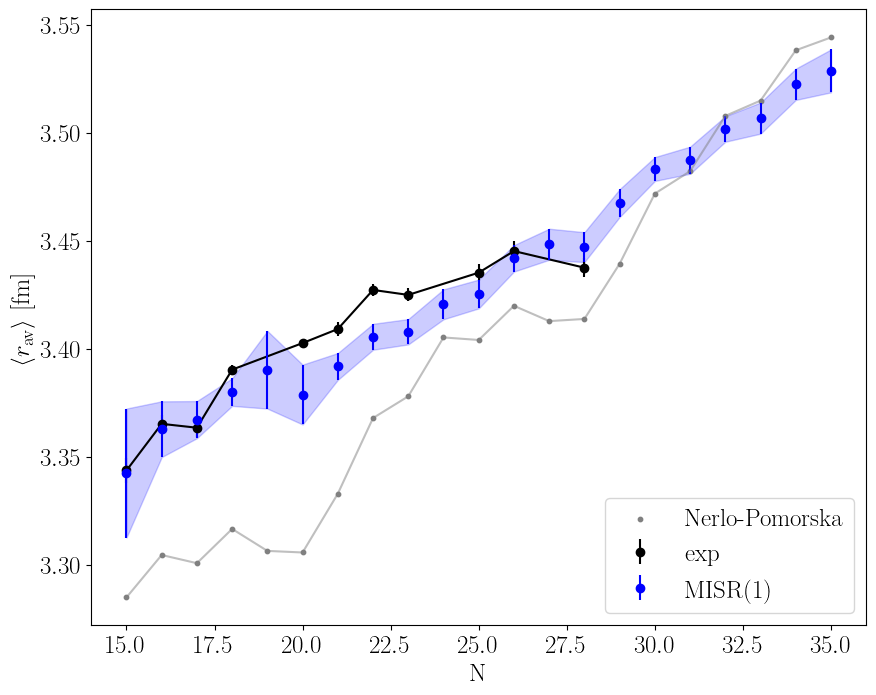

In [25]:
Z = 18
n_min, n_max = 15, 35
n_ref = 28
plot_range(Z, n_ref, n_min, n_max, index=1)

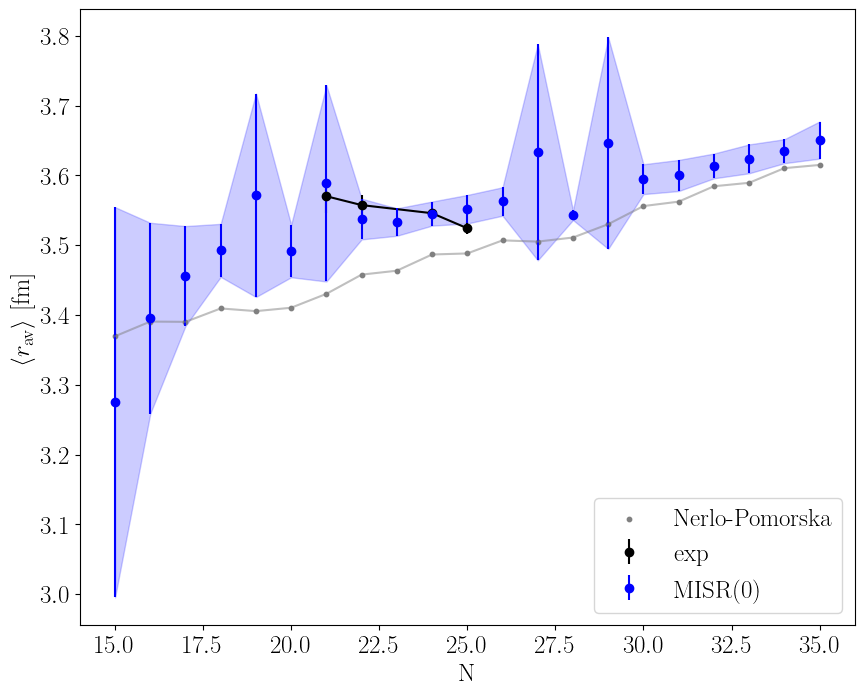

In [26]:
plot_range(21, n_ref, n_min, n_max, index=0)